# Optimization with Synthetic Data
In this notebook, optimization is performed with an SBML model and [PEtab](https://github.com/PEtab-dev/PEtab) parameter estimation problem, which includes some measurements.

Then, optimization is performed with synthetic data as measurements, which is generated using PEtab and [AMICI](https://github.com/AMICI-dev/AMICI). The ability to recover the parameter vector that was used to generate the synthetic data is demonstrated.

## Pre-requisites
This notebook requires PEtab and AMICI. These packages can be installed with `pip install petab amici`.

In [1]:
import amici
import matplotlib.pyplot as plt
import petab
import petab.simulate
import pypesto.optimize
import pypesto.petab
import pypesto.visualize

# Helper function to get the maximum likelihood estimate as a dictionary from a pyPESTO optimization result.
def get_x_mle(optimize_result, pypesto_problem, petab_problem, scaled=True):
    if not scaled:
        scaling = petab.parameters.get_optimization_parameter_scaling(petab_problem.parameter_df)
    return {
        x_id: (petab.parameters.unscale(x_value, scaling[x_id]) if not scaled else x_value)
        for x_id, x_value in zip(pypesto_problem.x_names, optimize_result.list[0]['x'])
        #if x_id in scaling
    }

In [2]:
petab_yaml_filename = 'conversion_reaction/conversion_reaction.yaml'
petab_problem_original = petab.Problem.from_yaml(petab_yaml_filename)

In [3]:
pypesto_importer_original = pypesto.petab.PetabImporter(petab_problem_original)
pypesto_problem_original = pypesto_importer_original.create_problem()

In [4]:
pypesto_result_original = pypesto.optimize.minimize(pypesto_problem_original, n_starts=100)

Function values from history and optimizer do not match: 2425.949798766003, 2632.872887924762
Parameters obtained from history and optimizer do not match: [ 1.70592201 -1.20602183], [-11.01302528  11.51292546]
Parameters obtained from history and optimizer do not match: [-0.25417536 -0.60835204], [-0.25416786 -0.60834108]
Parameters obtained from history and optimizer do not match: [ -0.91616693 -10.50632407], [ -0.91621033 -10.50631934]
Function values from history and optimizer do not match: 2612.8740976076006, 2632.8728829055135
Parameters obtained from history and optimizer do not match: [ 1.39696156 -3.25020771], [-11.51292546   9.65967931]


Parameters are estimated to be (linear scale):
k1: 0.7755701167620388
k2: 0.5442561792969075


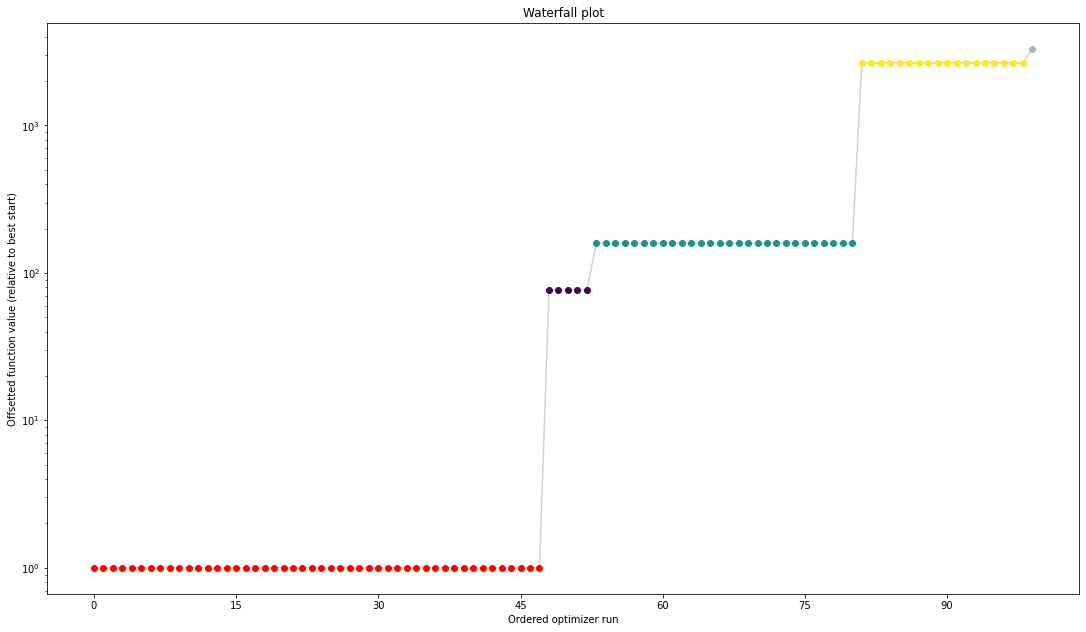

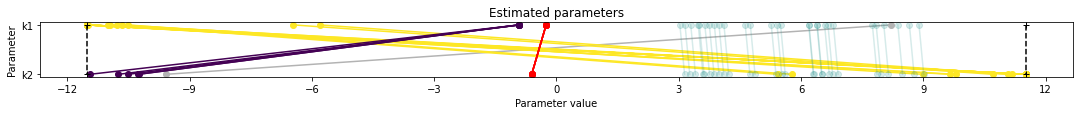

In [5]:
x_mle_unscaled_original = get_x_mle(pypesto_result_original.optimize_result,
                                    pypesto_problem_original,
                                    petab_problem_original,
                                    scaled=False)
print('Parameters are estimated to be (linear scale):')
print('\n'.join([f'{x_id}: {x_value}' for x_id, x_value in x_mle_unscaled_original.items()]))

pypesto.visualize.waterfall(pypesto_result_original);
pypesto.visualize.parameters(pypesto_result_original);

In [6]:
# TODO alternatively, copy.deepcopy(petab_problem_original)?
petab_problem_synthetic = petab.Problem.from_yaml(petab_yaml_filename)

synthetic_parameters = {'k1': 1.5, 'k2': 2.5}
petab_problem_synthetic.parameter_df[petab.C.NOMINAL_VALUE].update(synthetic_parameters)

simulator = petab.simulate.AmiciSimulator(petab_problem_synthetic)
# Optional: provide the simulator with a model, to avoid recompilation
simulator.set_model(pypesto_problem_original.objective.amici_model)
petab_problem_synthetic.measurement_df = simulator.simulate()

In [7]:
pypesto_importer_synthetic = pypesto.petab.PetabImporter(petab_problem_synthetic)
pypesto_problem_synthetic = pypesto_importer_synthetic.create_problem()
pypesto_result_synthetic = pypesto.optimize.minimize(pypesto_problem_synthetic, n_starts=100)

Parameters obtained from history and optimizer do not match: [0.38634106 0.86707992], [0.38633149 0.86707115]
Function values from history and optimizer do not match: 856.2902771395286, 1488.5960309582008
Parameters obtained from history and optimizer do not match: [ 0.31256086 -0.64772771], [-11.51292546  11.17775861]
Function values from history and optimizer do not match: 24.483351129815947, 1488.5960245323988
Parameters obtained from history and optimizer do not match: [0.99047425 1.22901793], [-9.29343328 11.51292546]


Parameters are estimated to be (linear scale):
k1: 1.471558145291193
k2: 2.3799089512020695


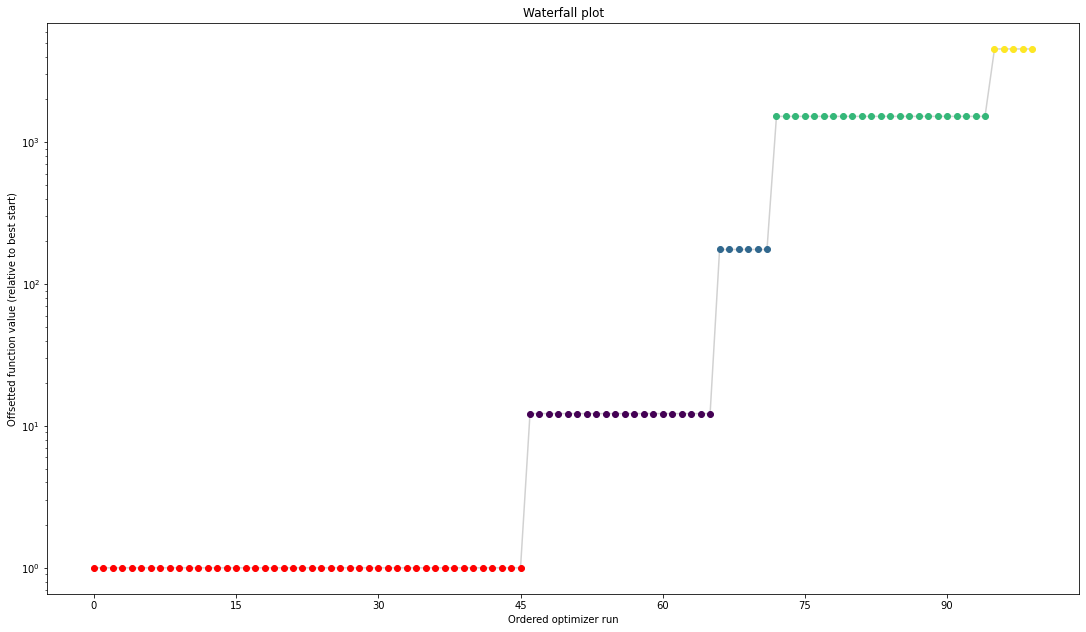

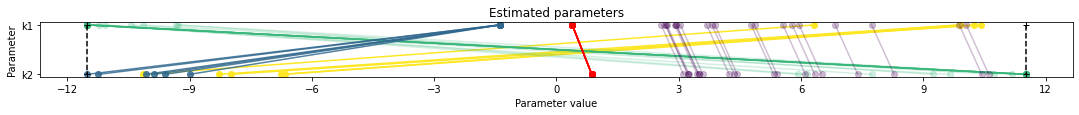

In [8]:
x_mle_unscaled_synthetic = get_x_mle(pypesto_result_synthetic.optimize_result,
                                     pypesto_problem_synthetic,
                                     petab_problem_synthetic,
                                     scaled=False)
print('Parameters are estimated to be (linear scale):')
print('\n'.join([f'{x_id}: {x_value}' for x_id, x_value in x_mle_unscaled_synthetic.items()]))

pypesto.visualize.waterfall(pypesto_result_synthetic);
pypesto.visualize.parameters(pypesto_result_synthetic);